INFO     [covid19_npis.data] Loaded data for Germany.
INFO     [covid19_npis.data] Loaded data for Finland.
INFO     [covid19_npis.model.distributions] I_0:
[[[[nan nan nan nan]
   [nan nan nan nan]]]]
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)
INFO     [covid19_npis.model.distributions] I_0:
[[nan nan nan nan]
 [nan nan nan nan]]
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)


tf.Tensor(
[[[ 428.83246  428.84174  428.82883  428.777  ]
  [ 389.76636  389.7917   389.66992  388.70413]]

 [[ 558.78204  558.8192   558.791    558.7044 ]
  [ 492.8949   492.9357   492.74774  491.26617]]

 [[ 727.2056   727.34283  727.2732   727.12823]
  [ 623.2127   623.2792   622.9996   620.8278 ]]

 [[ 943.2502   943.7374   943.54004  943.2803 ]
  [ 787.67224  787.7896   787.3787   784.2892 ]]

 [[1212.8931  1214.5704  1213.961   1213.4287 ]
  [ 994.48145  994.72455  994.1056   989.8001 ]]], shape=(5, 2, 4), dtype=float32)


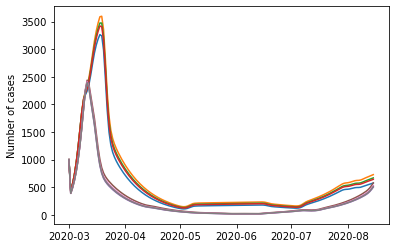

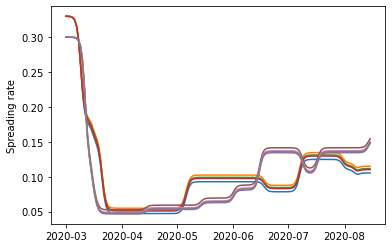

In [31]:
import sys
import logging
import time
import itertools
import os
import datetime
import functools

from tqdm import tqdm
import pandas as pd
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

sys.path.append("../../")
import covid19_npis
from covid19_npis.model import *


# Load data, it uses only the intervention data (when and which interventions were implemented)
# saved in interventions.csv in the respective country folder
# The length of the modelling is defined by the length of the files inside the country folders, 
# currently they are from the 2.3.2020 until the 15.8.2020
countries = [
    "Germany",
    "Finland",
]
c = [
    covid19_npis.data.Country(f"../../data/coverage_db/{country}",)
    for country in countries
]

# Construct our modelParams from the data.
modelParams = covid19_npis.ModelParams(countries=c, minimal_daily_deaths=0, offset_sim_data=1)



# Define the model
@pm.model()
def SIR_model(modelParams):
    lambda_0 = yield construct_lambda_0(
        name="lambda_0_c",
        modelParams=modelParams,
        loc=0.4,
        scale=0.1,
        hn_scale=0.05,  # Scale parameter of HalfNormal for each country
    )
    lambda_t = yield construct_R_t(
        name="lambda_t", modelParams=modelParams, R_0=lambda_0, include_noise = False
    )
    
    
    I_0_estimate = tf.reduce_mean(modelParams.pos_tests_data_tensor[1:6], axis=0)/0.6
    I_0 = (yield Normal(
        name="I_0_raw",
        loc = 0,
        scale=1,
        conditionally_independent=True,
        event_stack=(modelParams.num_countries, modelParams.num_age_groups),
    ))*I_0_estimate/6 + I_0_estimate
    I_0 = tf.math.softplus(I_0)
    log.info(f"I_0:\n{I_0}")

    
    I_0 = yield Deterministic(
        name="I_0", value=I_0, shape_label=("country", "age_group"),
    )
        

    C = tf.constant(np.stack(
        np.array(
            [
                [
                    [1, 0.1, 0.1, 0.1],
                    [0.1, 1, 0.1, 0.1],
                    [0.1, 0.1, 1, 0.1],
                    [0.1, 0.1, 0.1, 1],
                ]
            ]
            * 2
        )
    ), dtype = I_0.dtype)
    log.info(f"C:\n{C.shape}")
    log.debug(f"C:\n{C}")
    N = modelParams.N_data_tensor
    log.debug(f"N:\n{N}")
    new_I_t = InfectionModel_SIR(
        N=N,  I_0=I_0, lambda_t=lambda_t, C=C  
    )
    log.debug(f"new_I_t:\n{new_I_t[0,:]}")  # dimensons=t,c,a
    
    # Assume infections are positive tests
    positive_tests = yield Deterministic(
        name="positive_tests", value=new_I_t, shape_label=("time", "country", "age_group"),
    )
    
    
    yield covid19_npis.model.likelihood._studentT_positive_tests(modelParams, pos_tests=positive_tests)
    

# Define parameters for the test data set 
# These are defined not on the highest level, the sampling occurs on an unbounded space and
# some variables (for example alpha_i_c_a) depend on previous hierarchical variables. This allows
# to not define too many variables and nevertheless still get a test dataset.
params = {
    # population size per country and age group
    "N": np.array([[1e15, 1e15, 1e15, 1e15], [1e15, 1e15, 1e15, 1e15]]),
    # Reproduction number at t=0 per country and age group
    "lambda_0_c": np.array([0.33, 0.30]),
    # Initial infected
    "I_0": 1000 * np.array([[1, 1, 1, 1], [1, 1, 1, 1]]),
    # Change point date/index
    "delta_d_i": np.zeros((modelParams.num_interventions, 1, 1)),
    "delta_d_c": np.zeros((1, modelParams.num_countries, 1)),
    "sigma_d_interv": 0.3,
    "sigma_d_country": 0.3,
    # Length of the change point
    "l_i_sign": 4 * np.ones((modelParams.num_interventions,)),
    # Alpha value of the change point
    "alpha_i_c_a": np.stack(
        [[[0.78, 0.72, 0.74, 0.75], [0.78, 0.73, 0.76, 0.77]]]
        * modelParams.num_interventions
    )
    * 0.65,
    "C": np.stack(
        np.array(
            [
                [
                    [1, 0.1, 0.1, 0.1],
                    [0.1, 1, 0.1, 0.1],
                    [0.1, 0.1, 1, 0.1],
                    [0.1, 0.1, 0.1, 1],
                ]
            ]
            * 2
        )
    ),
}

# Create the test data
(
    positive_tests,
    lambda_t,
), trace = covid19_npis.test_data.data_generators.test_data_from_model(
    SIR_model,
    modelParams,
    params,
    [
        "positive_tests",
        "lambda_t",]
)


# Plot the data set for the test. 
# The first point is the total infection pool and not the new infections, that's why it is larger than the rest
plt.plot(positive_tests)
plt.ylabel("Number of cases")
plt.figure()
plt.plot(lambda_t)
plt.ylabel("Spreading rate")

# Set the test data set 
modelParams._dataframe_new_cases = positive_tests[1:] 
modelParams.pos_tests_data_tensor = positive_tests[1:]
positive_tests_formatted = modelParams.pos_tests_data_tensor[1:]
this_model = SIR_model(modelParams) 

print(modelParams.pos_tests_data_tensor[1:6])



INFO     [covid19_npis.model.distributions] I_0:
[[[1258.4968  1332.4786  1280.7711  1148.7036 ]
  [1139.9052   889.50977 1241.2621  1180.0413 ]]

 [[1410.1364  1193.1625  1332.834   1072.6176 ]
  [1115.1237  1258.9363   982.5112   940.12115]]

 [[1044.4746  1742.0468   782.8179  1007.35986]
  [ 857.46295 1478.4917   847.92126 1133.8643 ]]

 [[1295.0455  1435.7286  1653.8171  1303.515  ]
  [1218.7393  1053.0463   990.0487   988.3506 ]]

 [[1460.302    996.0637  1200.4015  1001.8003 ]
  [1303.2244   842.7394  1172.4819  1324.898  ]]]
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)
INFO     [covid19_npis.model.distributions] start
INFO     [covid19_npis.model.distributions] I_0:
[[1173.6188  1791.1401   838.2074   871.28564]
 [1105.3892  1120.4496  1126.5254  1044.8893 ]]
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)
Auto-assigning NUTS sampler
INFO     [pymc4.sampling] Auto-assigning NUTS sampler
INFO     [covid19_npis.model.distributions] I_0:
[[1589.2449  1684.8588

init state:
SIR_model|__SoftPlus_sigma_likelihood_pos_tests
[ 2.9531565 19.192156 ] 


INFO     [covid19_npis.model.distributions] I_0:
Tensor("Softplus_9:0", shape=(4, 2, 4), dtype=float32)
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)


WARNING  [tensorflow] 7 out of the last 11 calls to <function build_logp_and_deterministic_functions.<locals>.logpfn at 0x7f426587dee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
INFO     [covid19_npis.model.distributions] I_0:
Tensor("Softplus_9:0", shape=(4, 2, 4), dtype=float32)
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)
INFO     [covid19_npis.model.distributions] I_0:
Tensor("Softplus_9:0", shape=(4, 2, 4), dtype=flo

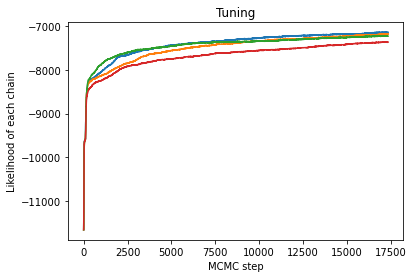

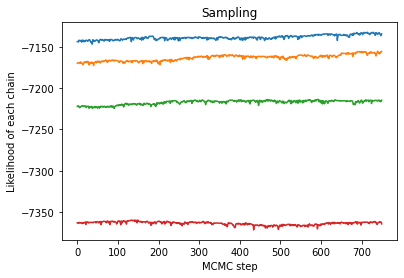

In [32]:
# Some checks
def print_dist_shapes(st):
    for name, dist in itertools.chain(
        st.discrete_distributions.items(), st.continuous_distributions.items(),
    ):
        if dist.log_prob(st.all_values[name]).shape != (5,):
            log.warning(
                f"False shape: {dist.log_prob(st.all_values[name]).shape}, {name}"
            )
    for p in st.potentials:
        if p.value.shape != (5,):
            log.warning(f"False shape: {p.value.shape} {p.name}")


_, sample_state = pm.evaluate_model_transformed(this_model, sample_shape=(5,))
print_dist_shapes(sample_state)


# Begin sampling
begin_time = time.time()
log.info("start")

num_chains = 4

trace_tuning, trace = pm.sample(
    this_model,
    num_samples=1000,
    num_samples_binning=50,
    burn_in_min=100,
    burn_in=15000,
    use_auto_batching=False,
    num_chains=num_chains,
    xla=True,
    initial_step_size=0.0001,
    ratio_tuning_epochs=1.5,
    max_tree_depth=4,
    decay_rate=0.75,
    target_accept_prob=0.75,
    step_size_adaption_per_chain=False
)

end_time = time.time()
log.info("running time: {:.1f}s".format(end_time - begin_time))


plt.figure()
plt.plot(trace_tuning.sample_stats["lp"].T)
plt.title("Tuning")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()

plt.figure()
plt.plot(trace.sample_stats["lp"].T)
plt.title("Sampling")
plt.ylabel('Likelihood of each chain')
plt.xlabel('MCMC step')
plt.show()




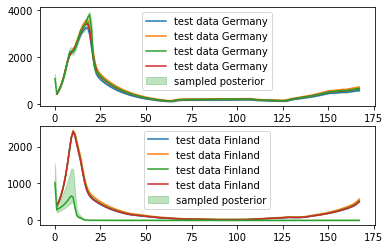

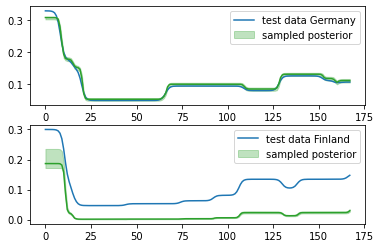

In [33]:
f, axes = plt.subplots(2)
positive_tests_formatted = modelParams.pos_tests_data_tensor[:]

x = np.arange(len(positive_tests))
axes[0].plot(np.array(positive_tests_formatted)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(positive_tests_formatted)[:,1], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|positive_tests'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


f, axes = plt.subplots(2)
x = np.arange(len(positive_tests))
axes[0].plot(np.array(lambda_t)[:,0], label='test data Germany')
axes[0].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3)), 
            color='tab:green')
axes[0].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,0,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)
axes[0].legend()
axes[1].plot(np.array(lambda_t)[:,4], label='test data Finland')
axes[1].plot(np.median(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3)), 
            color='tab:green')
axes[1].fill_between(x, *np.percentile(trace.posterior['SIR_model|lambda_t'][...,1,:], axis=(0,1,3), q=(2.5,97.5)), 
           label='sampled posterior', color='tab:green', alpha=0.3)

axes[1].legend()


In [25]:
plt.hist(trace.posterior["SIR_model|lambda_0_c"])

(168, 8)

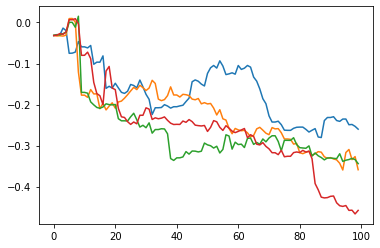

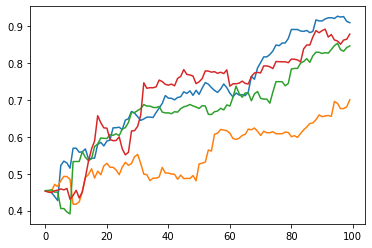

In [56]:
plt.plot(trace_tuning.posterior["SIR_model|delta_lambda_0_c"][:,:100,1].T)
plt.figure()
plt.plot(trace_tuning.posterior["SIR_model|delta_lambda_0_c"][:,:100,0].T)

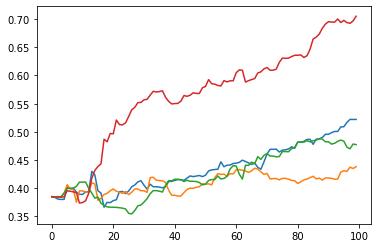

In [57]:
plt.plot(trace_tuning.posterior["SIR_model|lambda_0_sigma_c"][:,:100].T)

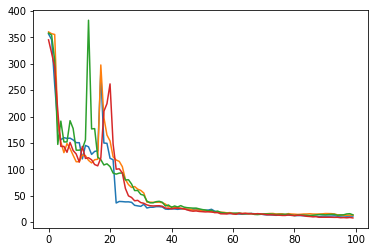

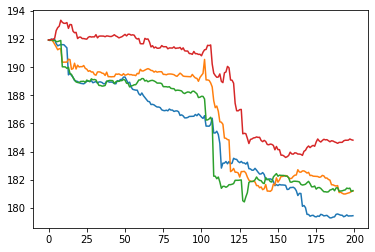

In [91]:
plt.plot(trace_tuning.posterior["SIR_model|positive_tests"][:,:100,25,1,1].T)
plt.figure()
plt.plot(trace_tuning.posterior["SIR_model|sigma_likelihood_pos_tests"][:,:200,1].T)

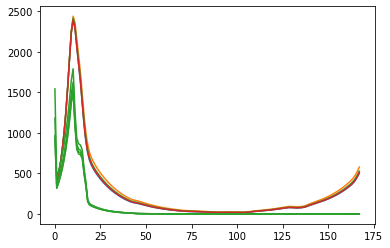

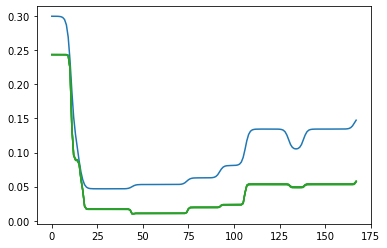

In [83]:
i=30
plt.plot(np.array(positive_tests_formatted)[:,1], label='test data Finland')
plt.plot(trace_tuning.posterior['SIR_model|positive_tests'][1,i,:,1,:],color='tab:green')
plt.figure()
plt.plot(np.array(lambda_t)[:,4], label='test data Finland')
plt.plot(trace_tuning.posterior['SIR_model|lambda_t'][1,i,...,1,:],color='tab:green')

In [92]:
modelParams.data_stratified_mask

AttributeError: 'ModelParams' object has no attribute 'data_stratified_mask'

In [58]:
trace.posterior

<xarray.Dataset>
Dimensions:                                                (SIR_model|I_0_dim_0: 2, SIR_model|I_0_dim_1: 4, SIR_model|I_0_raw_dim_0: 2, SIR_model|I_0_raw_dim_1: 4, SIR_model|__SoftPlus_sigma_likelihood_pos_tests_dim_0: 2, SIR_model|alpha_cross_i_dim_0: 5, SIR_model|alpha_cross_i_dim_1: 1, SIR_model|alpha_cross_i_dim_2: 1, SIR_model|alpha_i_a_dim_0: 5, SIR_model|alpha_i_a_dim_1: 4, SIR_model|alpha_i_c_a_dim_0: 5, SIR_model|alpha_i_c_a_dim_1: 2, SIR_model|alpha_i_c_a_dim_2: 4, SIR_model|d_i_c_p_dim_0: 5, SIR_model|d_i_c_p_dim_1: 2, SIR_model|d_i_c_p_dim_2: 5, SIR_model|delta_alpha_cross_a_dim_0: 1, SIR_model|delta_alpha_cross_a_dim_1: 1, SIR_model|delta_alpha_cross_a_dim_2: 4, SIR_model|delta_alpha_cross_c_dim_0: 1, SIR_model|delta_alpha_cross_c_dim_1: 2, SIR_model|delta_alpha_cross_c_dim_2: 1, SIR_model|delta_d_c_dim_0: 1, SIR_model|delta_d_c_dim_1: 2, SIR_model|delta_d_c_dim_2: 1, SIR_model|delta_d_i_dim_0: 5, SIR_model|delta_d_i_dim_1: 1, SIR_model|delta_d_i_dim_2: 1, SIR_model|delta_l_cross_i_dim_0: 5, SIR_model|delta_lambda_0_c_dim_0: 2, SIR_model|l_i_sign_dim_0: 5, SIR_model|l_negative_cross_dim_0: 1, SIR_model|l_positive_cross_dim_0: 1, SIR_model|lambda_0_c_dim_0: 2, SIR_model|lambda_t_dim_0: 168, SIR_model|lambda_t_dim_1: 2, SIR_model|lambda_t_dim_2: 4, SIR_model|positive_tests_dim_0: 168, SIR_model|positive_tests_dim_1: 2, SIR_model|positive_tests_dim_2: 4, SIR_model|sigma_likelihood_pos_tests_dim_0: 2, chain: 4, draw: 750)
Coordinates:
  * chain                                                  (chain) int64 0 1 2 3
  * draw                                                   (draw) int64 0 ......
  * SIR_model|delta_lambda_0_c_dim_0                       (SIR_model|delta_lambda_0_c_dim_0) int64 ...
  * SIR_model|delta_alpha_cross_c_dim_0                    (SIR_model|delta_alpha_cross_c_dim_0) int64 ...
  * SIR_model|delta_alpha_cross_c_dim_1                    (SIR_model|delta_alpha_cross_c_dim_1) int64 ...
  * SIR_model|delta_alpha_cross_c_dim_2                    (SIR_model|delta_alpha_cross_c_dim_2) int64 ...
  * SIR_model|alpha_cross_i_dim_0                          (SIR_model|alpha_cross_i_dim_0) int64 ...
  * SIR_model|alpha_cross_i_dim_1                          (SIR_model|alpha_cross_i_dim_1) int64 ...
  * SIR_model|alpha_cross_i_dim_2                          (SIR_model|alpha_cross_i_dim_2) int64 ...
  * SIR_model|delta_alpha_cross_a_dim_0                    (SIR_model|delta_alpha_cross_a_dim_0) int64 ...
  * SIR_model|delta_alpha_cross_a_dim_1                    (SIR_model|delta_alpha_cross_a_dim_1) int64 ...
  * SIR_model|delta_alpha_cross_a_dim_2                    (SIR_model|delta_alpha_cross_a_dim_2) int64 ...
  * SIR_model|delta_l_cross_i_dim_0                        (SIR_model|delta_l_cross_i_dim_0) int64 ...
  * SIR_model|l_positive_cross_dim_0                       (SIR_model|l_positive_cross_dim_0) int64 ...
  * SIR_model|l_negative_cross_dim_0                       (SIR_model|l_negative_cross_dim_0) int64 ...
  * SIR_model|delta_d_i_dim_0                              (SIR_model|delta_d_i_dim_0) int64 ...
  * SIR_model|delta_d_i_dim_1                              (SIR_model|delta_d_i_dim_1) int64 ...
  * SIR_model|delta_d_i_dim_2                              (SIR_model|delta_d_i_dim_2) int64 ...
  * SIR_model|delta_d_c_dim_0                              (SIR_model|delta_d_c_dim_0) int64 ...
  * SIR_model|delta_d_c_dim_1                              (SIR_model|delta_d_c_dim_1) int64 ...
  * SIR_model|delta_d_c_dim_2                              (SIR_model|delta_d_c_dim_2) int64 ...
  * SIR_model|I_0_raw_dim_0                                (SIR_model|I_0_raw_dim_0) int64 ...
  * SIR_model|I_0_raw_dim_1                                (SIR_model|I_0_raw_dim_1) int64 ...
  * SIR_model|__SoftPlus_sigma_likelihood_pos_tests_dim_0  (SIR_model|__SoftPlus_sigma_likelihood_pos_tests_dim_0) int64 ...
  * SIR_model|lambda_0_c_dim_0                             (SIR_model|lambda_0_c_dim_0) int64 ..

## Building a likelihood for other programs 

In [4]:
# Build likelihood function and a random initialization (from the prior)

from pymc4.mcmc.samplers import build_logp_and_deterministic_functions
(logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                                    this_model,
                                    collect_reduced_log_prob=False,)

# random_init is a dictionary with all values needed to calculate the likelihood. 
# logpfn requires the unbounded variables (as saved in random_init). 
# They can be passed either as dictionary or as list:
print(f"likelihood (of random init): {logpfn(**random_init)}")
print(f"likelihood (of random init): {logpfn(*list(random_init.values()))}")

INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)
INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)


likelihood (of random init): -16485.80859375


INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)


likelihood (of random init): -16485.80859375


### To get the number of cases and the lambda_t from a choice of parameters:


INFO     [covid19_npis.model.distributions] C:
(2, 4, 4)


Text(0, 0.5, 'spreading rate of random initialization')

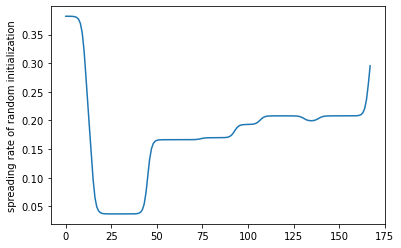

In [5]:

# Build a dummy trace, which requires extra chain and draw dimensions
dict_for_dummy_trace = {key:tf.cast(value, "float32")[tf.newaxis, tf.newaxis] 
                        for key,value in random_init.items()}
trace_tmp = az.from_dict(posterior=dict_for_dummy_trace)


variables = ["lambda_t", "positive_tests"]
model_name = "SIR_model"
var_names = []
for var in variables:
    var_names.append(f"{model_name}|{var}")

# And sample it from the model. It will use the variables saved in trace_tmp, if there is one variable
# not defined, it is randomly chosen from its distribution. 
trace_res = pm.sample_posterior_predictive(
    SIR_model(modelParams), trace_tmp, var_names=var_names, use_auto_batching=False,
)

# And plot the resulting spreading rate, it is saved in trace_res.posterior_predictive 
plt.plot(trace_res.posterior_predictive["SIR_model|lambda_t"][0,0,:,1,0])
plt.ylabel("spreading rate of random initialization")

In [6]:
sample_state.transformed_values.keys()

dict_keys(['SIR_model|__SoftPlus_lambda_0_sigma_c', 'SIR_model|__SoftPlus_alpha_sigma_country', 'SIR_model|__SoftPlus_alpha_sigma_age_group', 'SIR_model|__SoftPlus_l_sigma_interv', 'SIR_model|__SoftPlus_d_sigma_interv', 'SIR_model|__SoftPlus_d_sigma_country', 'SIR_model|__SoftPlus_sigma_likelihood_pos_tests'])

In [7]:
trace_tuning.sample_stats['SIR_model|tree_size']

KeyError: 'SIR_model|tree_size'

In [ ]:
random_inits = []
n_inits = 20
for i in range(n_inits):
    (logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                                    this_model,
                                    collect_reduced_log_prob=False,num_chains =100)
    random_inits.append(random_init)

for 
    
logpfn(**random_inits[-1])
begin_time = time.time()
for random_init in random_inits:
    a = logpfn(**random_init)

end_time = time.time()
log.info("running time: {:.1f}ms".format((end_time - begin_time)*1000/n_inits))

In [ ]:
from pymc4.mcmc.utils import initialize_sampling_state
from pymc4.mcmc.samplers import tile_init
nchains = 1
niter = 50

def merge_init(init_states):
    init = []
    for i in range(len(init_states[0])):
        init.append(tf.stack([init_state[i] for init_state in init_states]))
    return init

inits = []

for i in range(niter):
    init_chains = []
    for j in range(nchains):
        state, deterministic_names = initialize_sampling_state(this_model)
        init = dict(state.all_unobserved_values)
        init_state = list(init.values())
        init_chains.append(init_state)
    init_state = merge_init(init_chains)
    inits.append(init_state)

(logpfn,random_init,_,_,state_,) = build_logp_and_deterministic_functions(
                            this_model,
                            collect_reduced_log_prob=False,num_chains =nchains)
    
logpfn(*inits[-1])
begin_time = time.time()
for init in inits:
    a = logpfn(*init)
end_time = time.time()
log.info("running time: {:.1f}ms".format((end_time - begin_time)*1000/nchains/niter))
    

In [ ]:
n_eval = np.sum(trace.sample_stats['tree_size']+1) + np.sum(trace.sample_stats['tree_size']+1)

In [ ]:
n_eval

In [ ]:
@tf.function(experimental_compile=True)
def InfectionModel_SIR_test(N, I_0, C, T, recov_rate=1 / 8, h_t=None):
    r"""
    This function combines a variety of different steps:

        #. Converts the given :math:`E_0` values  to an exponential distributed initial :math:`E_{0_t}` with an
           length of :math:`l` this can be seen in :py:func:`_construct_E_0_t`.

        #. Calculates :math:`R_{eff}` for each time step using the given contact matrix :math:`C`:

            .. math::
                R_{diag} &= \text{diag}(\sqrt{R}) \\
                R_{eff}  &= R_{diag} \cdot C \cdot R_{diag}

        #. Calculates the :math:`\tilde{I}` arrays i.e. new infectious for each age group and
           country, with the efficient reproduction matrix :math:`R_{eff}`, the susceptible pool
           :math:`S`, the population size :math:`N` and the generation interval :math:`g(\tau)`.
           This is done recursive for every time step.

            .. math::
                    \tilde{I}(t) &= \frac{S(t)}{N} \cdot R_{eff} \cdot \sum_{\tau=0}^{t} \tilde{I}(t-1-\tau) g(\tau) \\
                    S(t) &= S(t-1) - \tilde{I}(t-1)

    Parameters
    ----------
    N:
        Total population per country
        |shape| country, age_group
    I_0_t:
        Initial number of infectious.
        |shape| batch_dims, country, age_group
    lambda_t:
        spreading rate matrix.
        |shape| time, batch_dims, country, age_group

    C:
        inter-age-group Contact-Matrix (see 8)
        |shape| country, age_group, age_group
    recov_rate:
        recovery rate
        |shape| batch_dims, country, age_group
    h_t:
        eventual external input
        |shape| time, batch_dims, country, age_group
    Returns
    -------
    :
        Sample from distribution of new, daily cases
    """

    # @tf.function(autograph=False)

    # For robustness of inference
    # R_t = tf.clip_by_value(R_t, 0.5, 7)
    # R_t = tf.clip_by_norm(R_t, 100, axes=0)
    
    with tf.GradientTape() as tape:
        lambda_ = tf.ones_like(I_0)*recov_rate + 0.00001

        def loop_body(params, elems):
            # Unpack a:
            # Old E_next is E_lastv now
            h = elems
            _, I_last, S_t = params  # Internal state

            # Internal state
            f = S_t / N

            # log.debug(f"I_t {I_t}")

            # Calculate effective lambda_t [country,age_group] from Contact-Matrix C [country,age_group,age_group]
            lambda_sqrt = tf.math.sqrt(lambda_ + 1e-7)
            lambda_diag = tf.linalg.diag(lambda_sqrt)
            lambda_eff = tf.einsum(
                "...ij,...ik,...kl->...il", lambda_diag, C, lambda_diag
            )  # Effective growth number

            # log.debug(f"infectious: {infectious}")
            # log.debug(f"R_eff:\n{R_eff}")
            # log.debug(f"f:\n{f}")
            # log.debug(f"h:\n{h}")

            # Calculate new infections
            infections = tf.einsum("...ci,...cij,...cj->...cj", I_last, lambda_eff, f) + h
            infections = tf.clip_by_value(infections, 0.01, 1e9)  # for robustness

            # Calculate new infectious pool
            I_new = infections + I_last - recov_rate * I_last

            return infections, I_new, S_t

        # Number of days that we look into the past for our convolution

        S_initial = N - I_0

        len_added = 1

        lambda_t_for_loop = lambda_t[len_added:]
        if not h_t:
            h_t_for_loop = tf.zeros([T] + list(I_0.shape))
        else:
            h_t_for_loop = h_t[len_added:]
        # Initial susceptible population = total - infected

        """ Calculate time evolution of new, daily infections
            as well as time evolution of susceptibles
            as lists
        """

        initial = (
            tf.zeros_like(S_initial),
            I_0,
            S_initial,
        )
        out = tf.scan(
            fn=loop_body, elems=(h_t_for_loop), initializer=initial
        )
        daily_infections_final = out[0]
        daily_infections_final = tf.concat(
            [I_0[tf.newaxis, ...], daily_infections_final], axis=0
        )

        # Transpose tensor in order to have batch dim before time dim
        daily_infections_final = tf.einsum("t...ca->...tca", daily_infections_final)

        log.debug(f"daily_infections_final:\n{daily_infections_final}")
        log.debug(
            f"daily_infections_final sum:\n{tf.reduce_sum(daily_infections_final, axis=-3)}"
        )
        daily_infections_final = tf.clip_by_value(daily_infections_final, 1e-6, 1e6)

    return tape.gradient(daily_infections_final, [I_0,C])
    #return tf.gradients(daily_infections_final, [I_0, C])
    #return daily_infections_final


niter = 50
n_countries = 20
N = tf.ones((n_countries,1))*1e15
I_0 = tf.ones((n_countries,1))*20.
C = tf.ones((1,1))
T = 400
I_0 = tf.Variable(I_0)
C = tf.Variable(C)
InfectionModel_SIR_test(N, I_0, C, T)
begin_time = time.time()
for i in range(niter):
    I_0_rand = I_0 + tf.random.normal([])
    a = InfectionModel_SIR_test(N, I_0_rand, C, T)
end_time = time.time()  
print(a)
log.info("running time: {:.3f}ms".format((end_time - begin_time)*1000/niter/T*170/n_countries*2))